In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("API_KEY")


In [81]:
# pip install --upgrade google-auth-oauthlib google-auth-httplib2
# pip install --upgrade google-api-python-client

from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd

from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('classic')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
from funcs import *
plt.style.use('ggplot')

In [33]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

In [4]:
# Link to get channel ids: https://commentpicker.com/youtube-channel-id.php
channel_ids = ['UCqECaJ8Gagnn7YCbPEzWH6g',
               'UCuHzBCaKmtaLcRAOoazhCPA',
               'UCHnyfMqiRRG1u-2MsSQLbXA'
              ]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [9]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Veritasium,13800000,2128607127,365,UUHnyfMqiRRG1u-2MsSQLbXA
1,Taylor Swift,52300000,29468137970,214,UUqECaJ8Gagnn7YCbPEzWH6g
2,Beyoncé,25900000,17276324532,239,UUuHzBCaKmtaLcRAOoazhCPA


In [29]:
# Get video IDs
# 1. Go to your target YouTube playlist on the browser.
# 2. On the address bar, you will see something like this: https://www.youtube.com/watch?v=RLykC1VN7NY&list=PLFs4vir_WsTwEd-nJgVJCZPNL3HALHHpF
# 3. The playlist ID is the characters after “list=” so in the URL above, our playlist ID is PLFs4vir_WsTwEd-nJgVJCZPNL3HALHHpF
# 4. Copy the playlist ID.

playlist_id = "PL_TqAU4yPHO4J_5jlmqxM7H6_HGMrYSYb"
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)


11

In [34]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,jAfLFgdhfDQ,Cifra Club,ANUNCIAÇÃO - Alceu Valença (aula simplificada)...,Preparados para aprender a tocar um clásico da...,"[Cifra Club, cifra club violão, mpb, mpb cifra...",2021-02-10T22:00:09Z,353010,10569,None,341,PT9M33S,hd,false
1,rdRU70rKmkE,Cifra Club,TÁ ROCHEDA - Os Barões da Pisadinha (aula comp...,Chaaama!🎤 Caico Antunes vai te ensinar a tocar...,"[Cifra Club, como tocar violão, ta rocheada, b...",2020-11-11T23:00:06Z,251055,13151,None,486,PT7M45S,hd,false
2,EFSBDHLOZA0,Cifra Club,EU SÓ QUERO UM XODÓ - Gilberto Gil (aula simpl...,Pega seu violão e vem curtir esse forró arreta...,"[Cifra Club, aula de violão, violão cifra club...",2020-10-10T16:00:02Z,117413,5010,None,218,PT6M52S,hd,false
3,UswqJvroH3E,Cifra Club,Asa Branca - Luíz Gonzaga (aula de violão comp...,INSCREVA-SE: http://bit.ly/1240tnX\nAula + cif...,"[Luíz Gonzaga, Asa Branca, como, tocar, violão...",2010-05-19T01:43:46Z,1649452,16829,None,334,PT17M24S,hd,false
4,MC6LuUWD6iE,Cifra Club,La Belle De Jour - Alceu Valença (aula de viol...,"Cifra, tab e aula com divisão em capítulos em ...","[cifra club, how to play, como tocar, como, to...",2015-01-14T19:38:05Z,1400249,27676,None,1017,PT25M36S,hd,false
5,tLdsurRiA8I,Cifra Club,OH! CHUVA - Falamansa (aula completa) | Como t...,Vem saber como tocar a versão completa de Oh! ...,"[Cifra Club, aula de violão, como tocar violão...",2020-04-19T15:00:45Z,206652,8774,None,283,PT13M11S,hd,false
6,XiCdrRGvuNM,Cifra Club,ESPERANDO NA JANELA - Gilberto Gil (aula compl...,Tá com saudade de um arrasta-pé né?! Calma que...,"[Cifra Club, violão, como tocar violão, quero ...",2020-08-27T21:30:03Z,111060,4728,None,231,PT24M13S,hd,false
7,RiwEC8N5Wjo,Cifra Club,A LUA ME TRAIU - Banda Calypso | Como tocar na...,Pega aí sua guitarra e vem conferir a aula de ...,"[Cifra Club, como tocar, guitarra, how to play...",2020-03-16T21:00:12Z,122045,11315,None,758,PT20M15S,hd,false
8,ubwNE1ejeJI,Cifra Club,GIRASSOL - Alceu Valença (aula de violão simpl...,"Cifra, tab e aula com divisão em capítulos em ...","[cifra club, how to play, como tocar, como, to...",2017-09-28T17:03:56Z,207002,4921,None,109,PT8M50S,hd,false
9,d2ixzpRzn4E,Cifra Club,Ritmos Brasileiros No Pandeiro | COMO TOCAR PA...,"Na terceira aula, em parceira com a Torelli Mu...","[Cifra Club, curso de percussão, curso de pand...",2019-10-10T21:00:02Z,79874,4188,None,85,PT13M56S,hd,false


In [35]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [36]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [37]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [38]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [63]:
# Convert the duration column to timedelta format
video_df['duration'] = pd.to_timedelta(video_df['duration'])

# Extract the total duration in seconds
video_df['durationSecs'] = video_df['duration'].dt.total_seconds().astype(int)

video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,573,0 days 00:09:33
1,465,0 days 00:07:45
2,412,0 days 00:06:52
3,1044,0 days 00:17:24
4,1536,0 days 00:25:36
5,791,0 days 00:13:11
6,1453,0 days 00:24:13
7,1215,0 days 00:20:15
8,530,0 days 00:08:50
9,836,0 days 00:13:56


In [64]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [65]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,jAfLFgdhfDQ,Cifra Club,ANUNCIAÇÃO - Alceu Valença (aula simplificada)...,Preparados para aprender a tocar um clásico da...,"[Cifra Club, cifra club violão, mpb, mpb cifra...",2021-02-10 22:00:09+00:00,353010.0,10569.0,NaN,341.0,0 days 00:09:33,hd,false,Wednesday,573,18
1,rdRU70rKmkE,Cifra Club,TÁ ROCHEDA - Os Barões da Pisadinha (aula comp...,Chaaama!🎤 Caico Antunes vai te ensinar a tocar...,"[Cifra Club, como tocar violão, ta rocheada, b...",2020-11-11 23:00:06+00:00,251055.0,13151.0,NaN,486.0,0 days 00:07:45,hd,false,Wednesday,465,14
2,EFSBDHLOZA0,Cifra Club,EU SÓ QUERO UM XODÓ - Gilberto Gil (aula simpl...,Pega seu violão e vem curtir esse forró arreta...,"[Cifra Club, aula de violão, violão cifra club...",2020-10-10 16:00:02+00:00,117413.0,5010.0,NaN,218.0,0 days 00:06:52,hd,false,Saturday,412,14
3,UswqJvroH3E,Cifra Club,Asa Branca - Luíz Gonzaga (aula de violão comp...,INSCREVA-SE: http://bit.ly/1240tnX\nAula + cif...,"[Luíz Gonzaga, Asa Branca, como, tocar, violão...",2010-05-19 01:43:46+00:00,1649452.0,16829.0,NaN,334.0,0 days 00:17:24,hd,false,Wednesday,1044,36
4,MC6LuUWD6iE,Cifra Club,La Belle De Jour - Alceu Valença (aula de viol...,"Cifra, tab e aula com divisão em capítulos em ...","[cifra club, how to play, como tocar, como, to...",2015-01-14 19:38:05+00:00,1400249.0,27676.0,NaN,1017.0,0 days 00:25:36,hd,false,Wednesday,1536,25
5,tLdsurRiA8I,Cifra Club,OH! CHUVA - Falamansa (aula completa) | Como t...,Vem saber como tocar a versão completa de Oh! ...,"[Cifra Club, aula de violão, como tocar violão...",2020-04-19 15:00:45+00:00,206652.0,8774.0,NaN,283.0,0 days 00:13:11,hd,false,Sunday,791,22
6,XiCdrRGvuNM,Cifra Club,ESPERANDO NA JANELA - Gilberto Gil (aula compl...,Tá com saudade de um arrasta-pé né?! Calma que...,"[Cifra Club, violão, como tocar violão, quero ...",2020-08-27 21:30:03+00:00,111060.0,4728.0,NaN,231.0,0 days 00:24:13,hd,false,Thursday,1453,21
7,RiwEC8N5Wjo,Cifra Club,A LUA ME TRAIU - Banda Calypso | Como tocar na...,Pega aí sua guitarra e vem conferir a aula de ...,"[Cifra Club, como tocar, guitarra, how to play...",2020-03-16 21:00:12+00:00,122045.0,11315.0,NaN,758.0,0 days 00:20:15,hd,false,Monday,1215,25
8,ubwNE1ejeJI,Cifra Club,GIRASSOL - Alceu Valença (aula de violão simpl...,"Cifra, tab e aula com divisão em capítulos em ...","[cifra club, how to play, como tocar, como, to...",2017-09-28 17:03:56+00:00,207002.0,4921.0,NaN,109.0,0 days 00:08:50,hd,false,Thursday,530,20
9,d2ixzpRzn4E,Cifra Club,Ritmos Brasileiros No Pandeiro | COMO TOCAR PA...,"Na terceira aula, em parceira com a Torelli Mu...","[Cifra Club, curso de percussão, curso de pand...",2019-10-10 21:00:02+00:00,79874.0,4188.0,NaN,85.0,0 days 00:13:56,hd,false,Thursday,836,12


# EDA

### Best performing videos

C:\Users\camil\AppData\Local\Temp\ipykernel_18512\207731052.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


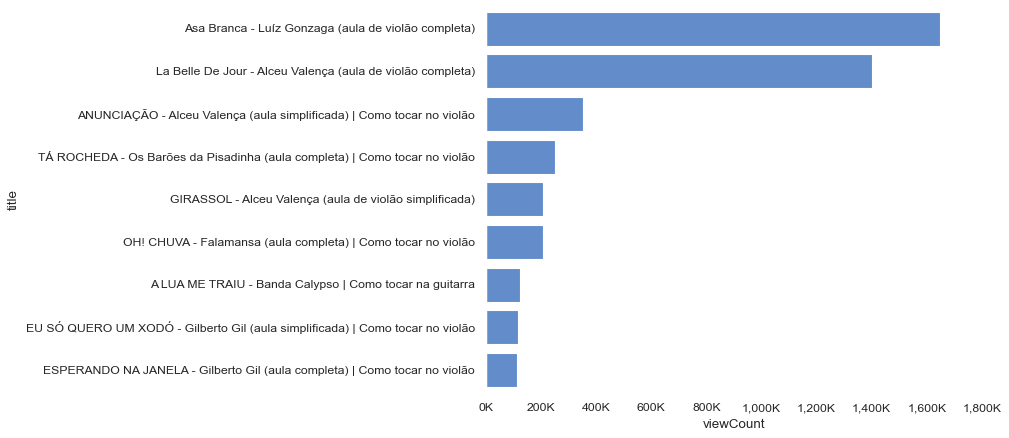

In [102]:

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
ax = sns.barplot(y = 'title', x = 'viewCount', color='#5288db',data = video_df.sort_values('viewCount', ascending=False)[0:9])
#plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))




### Worst performing videos

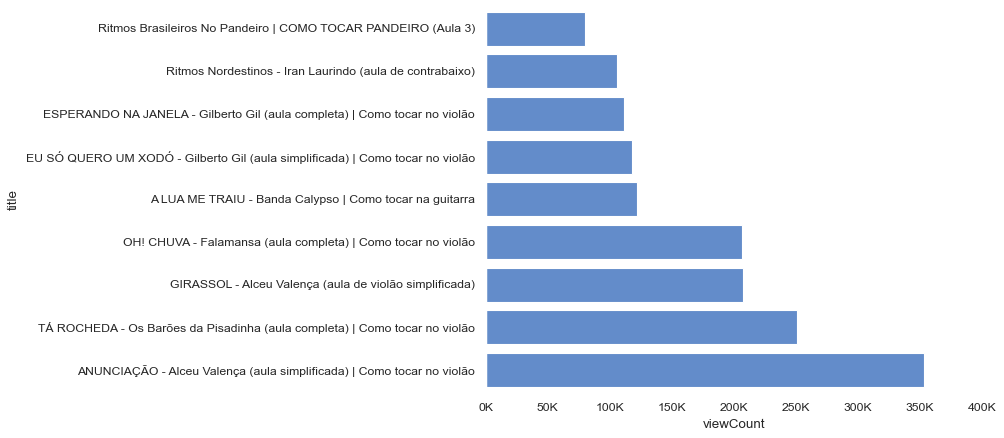

In [105]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
ax = sns.barplot(y = 'title', x = 'viewCount', color='#5288db', data = video_df.sort_values('viewCount', ascending=True)[0:9])
# plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video

<AxesSubplot: >

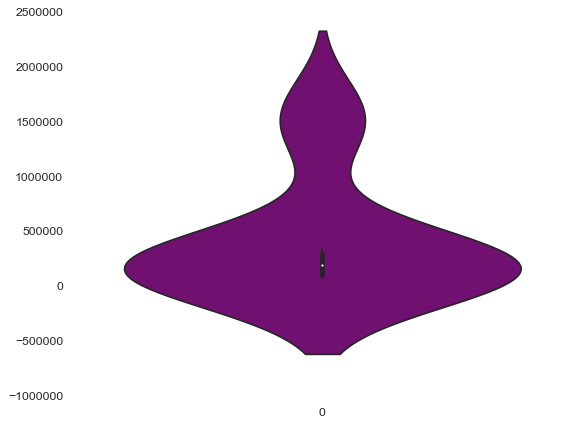

In [108]:
sns.violinplot(video_df['viewCount'], color='purple')

### Views vs. likes and comments

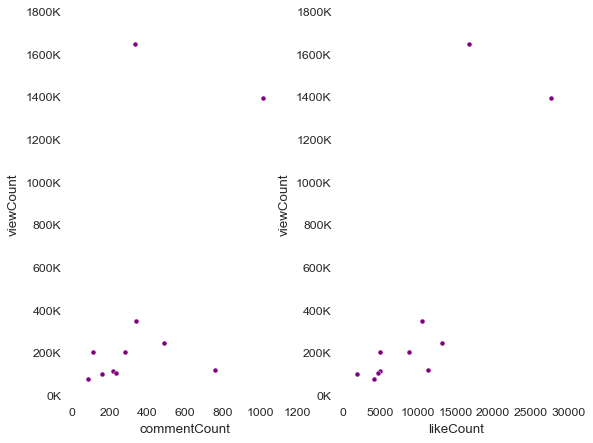

In [122]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0], color = 'purple')
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1], color = 'purple')
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:.0f}'.format(x/1000) + 'K'))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:.0f}'.format(x/1000) + 'K'))

### Video duration

<AxesSubplot: xlabel='durationSecs', ylabel='Count'>

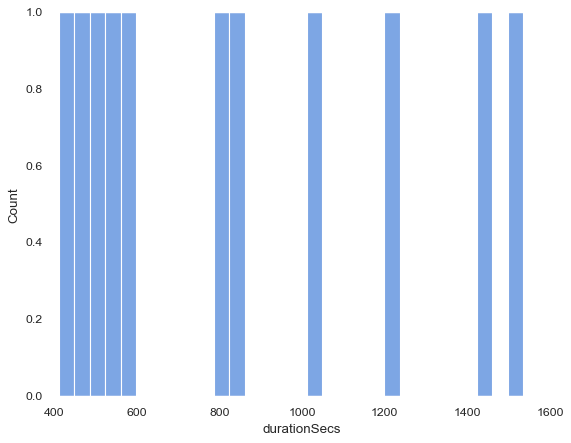

In [123]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30, color = "#5288db")

### Wordcloud for video titles

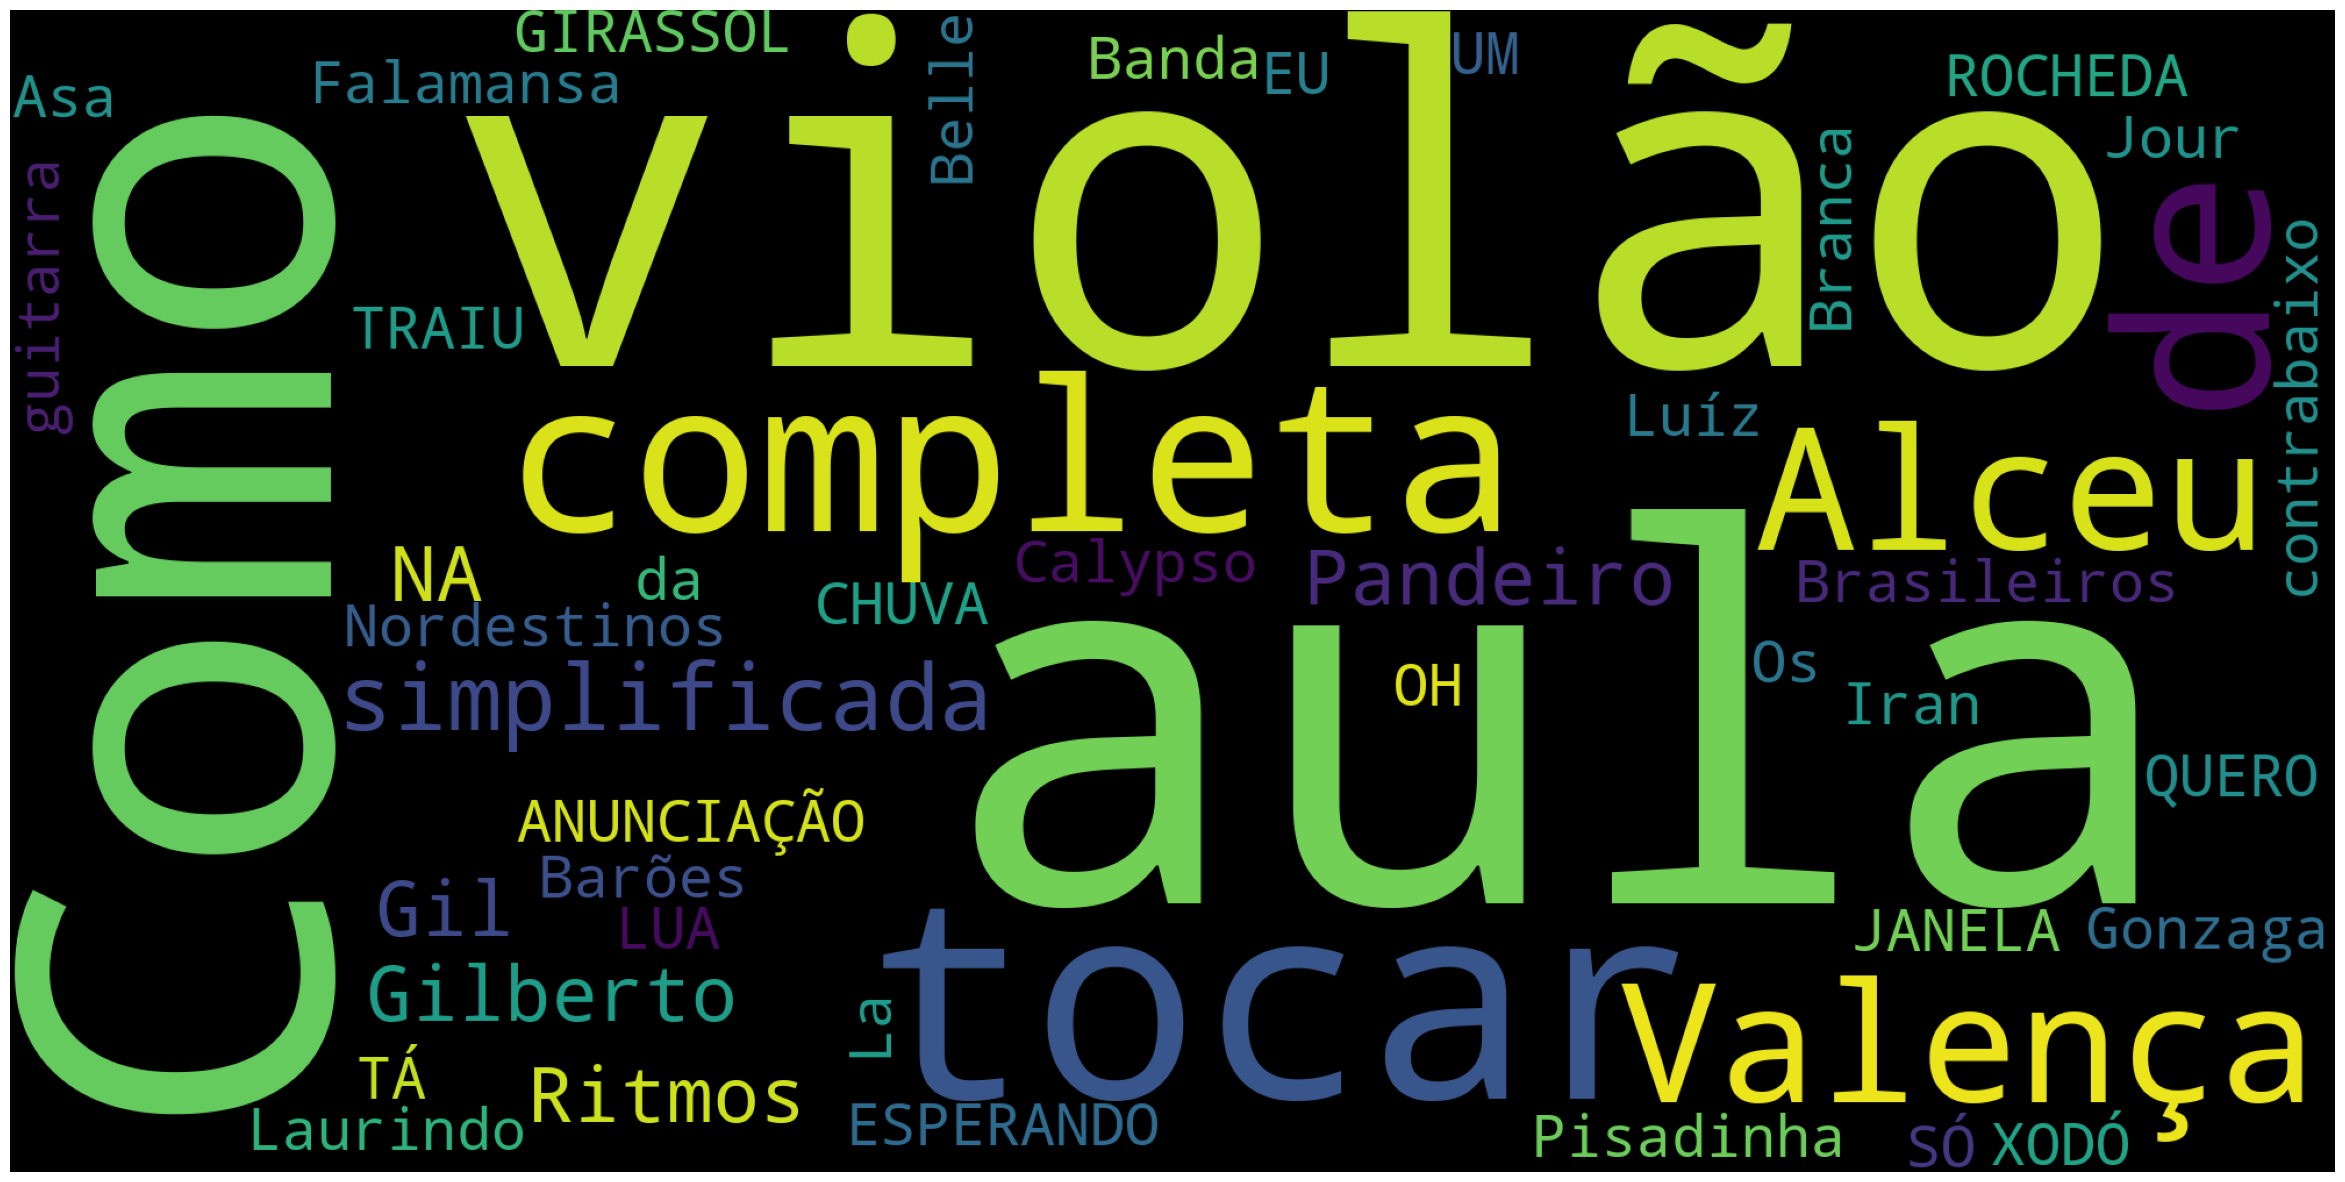

In [71]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Upload schedule

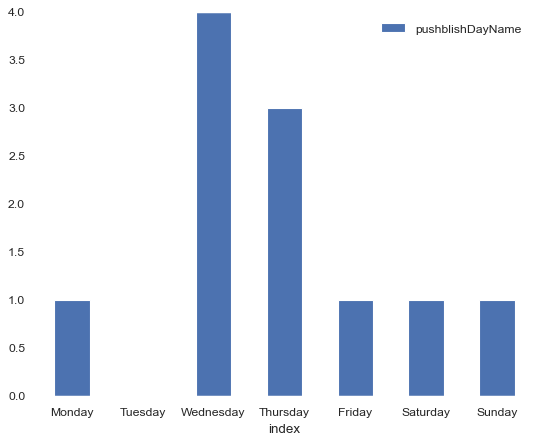

In [119]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)